In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
import os
import shutil
import time

# Plot Space average of u(t)

In [3]:
dt = 0.1
tspan = 19
tspan/dt

190.0

In [4]:
dx = 0.1
L = 64
R0 = 25

In [5]:
T = 25
C0 = 1
A = 1

In [6]:
title = "Circular island R0 = "+str(R0)+"\n$C = "+ str(C0) + " + "+str(A)+"*sin(2\pi t/"+str(T)+")$\n"
title = title + "dt = " + str(dt) + " dx = " + str(dx) + " L = " + str(L)

# Motion by curvature
As the border is circular, here we check motion by curvature ($v=-\kappa$) by checking the relation
$$R^2 = 2(t_{coll} - t)$$
where $t_{coll}$ is the time when the island collapses to $R=0$.

It is simpler to check this relation instead of calculating $dv/dt$ and $1/\kappa$.

190


ValueError: negative dimensions are not allowed

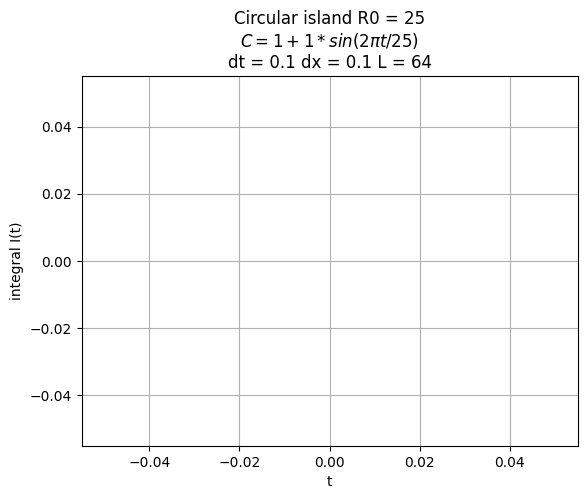

In [7]:
f = open("../fileAveout.dat", "r")
N = int(round(tspan/dt))
tt = np.zeros(N)
ave = np.zeros(N)

i = 0
for row in f:
    a, b = row.split(" ")
    tt[i] = float(a)
    ave[i] = float(b)
    #print(ave[i])
    i = i + 1

if(N-i != 0):
    print("WARNING: dt or tspan is incorrect!")

# Calculate the radius (by exploiting tanh, and we expect even corrections to it, are ODD in (r-R))
area = (ave+np.ones(N))*L**2/2
r2 = np.zeros(len(area))                # Radius squared R^2
for i in np.arange(0, len(area)):
    r2[i] = area[i]/np.pi
    #print(str(area[i]) + " " + str(i))

# Times to plot
ts = np.arange(0, tt[len(tt)-1], dt)
ns = np.arange(0, len(ts))
for i in np.arange(0,len(ns)):
    ns[i] = int(ts[i]/dt)
#ts = np.arange(0, i, int(T/dt))

# Motion by curvature
fig, ax = plt.subplots()
ax.plot(tt[ns], r2[ns],'.', label="Experiment")
ax.set_xlabel("t")
ax.set_ylabel("integral I(t)")
ax.grid()
ax.set_title(title)

# True analytical (taking into account we're extimating R^2 only on average)
#Read C(t)
f = open("../fileCout.dat", "r")
N = int(round(tspan/dt))
tt = np.zeros(N)
Cs = np.zeros(N)
integral_anal = np.zeros(N)
i = 0
for row in f:
    a, b = row.split(" ")
    if i > 0:
        tt[i-1] = float(a)
        Cs[i-1] = float(b)
        integral_anal[i-1] = np.sqrt(Cs[i-1])*(R0*R0-2*tt[i-1]-L*L/(2*np.pi)) + L*L/(2*np.pi)

    #print(ave[i])
    i = i + 1
print(i)
ax.plot(tt[ns[0:len(ns)-1]], integral_anal[ns[0:len(ns)-1]], "--", label="Analytical integral I, motion by curvature")
# Analytical motion by curvature
r2_anal = R0*R0*np.ones(len(r2)) - 2*tt
ax.plot(tt[ns], r2_anal[ns], "--", label="Analytical R^2, motion by curvature", color="red")

# Calculate the average over a period
nT = int(T/dt)  # Number of steps corresponding to a period
r2ave = np.zeros(len(r2)-nT)
nsave = np.arange(0,len(tt)-nT)
for i in np.arange(0, len(r2)):
    if i >= nT:
        r2ave[i-nT] = np.average(r2[ns[i-nT]:ns[i]])
        nsave[i-nT] = ns[int(i-nT/2)]
ax.plot(tt[nsave], r2ave, "--", label="Average over [t+-T/2]")


ax.legend()
t_min = 40
t_max = t_min + 50*T
#ax.set_xlim(t_min,t_max)
#ax.set_ylim(2410,2432)

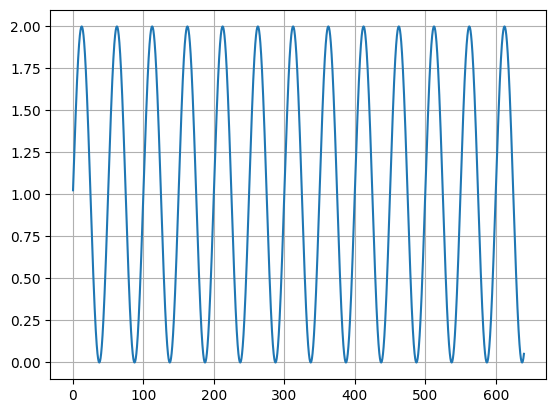

In [ ]:
plt.plot(tt[0:len(tt)-1], Cs[0:len(tt)-1])
plt.grid()

In [ ]:
tt[len(integral_anal)-1]

0.0

In [ ]:
r2[ns[0]]

2501.364143008307

# Plot final state u(x, tmax)

/tmp/ipykernel_10322/57184770.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.get_cmap('Blues'))


Text(0.5, 1.0, '$\\sqrt{(\\partial_x u)^2 + (\\partial_y u)^2}$\nt = 114.000000')

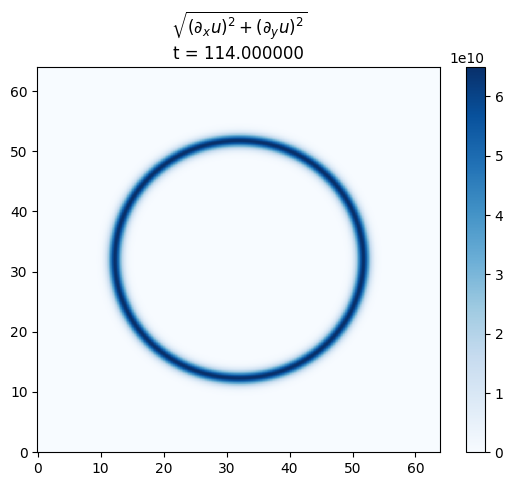

In [28]:
f = open("../state_gradient.dat", "r")
N = int(L/dx)
x = np.zeros(N)
y = np.zeros(N)
Z = np.zeros((N,N))
i = 0
for row in f:
    if i != 0:
        a, b, c = row.split(" ")
        #a, b = row.split("	")
        J = np.mod(i-1,N)
        I = int((i-1)/N)
        x[I] = float(a)
        y[J] = float(b)
        Z[I][J] = float(c)
    else:
        N, tmax, dx = row.split(" ")
        dx = float(dx)
        N = int(N)

    i = i + 1

#x = x[0:i-1]
#y = y[0:i-1]

# Make up some fake data
X,Y = np.meshgrid(x,y)

fig = plt.figure(figsize = (6.5,5))
fig.subplots_adjust(wspace=0.3)

# Blues
#plt.figure(figsize=(10,10))
plt.pcolormesh(X, Y, Z, cmap=plt.cm.get_cmap('Blues'))
plt.colorbar()
#plt.axis([-3, 3, -3, 3])
plt.title('$\sqrt{(\partial_x u)^2 + (\partial_y u)^2}$\nt = ' + str(tmax))
#plt.title("t = " + str(tmax))

3.58261369199603


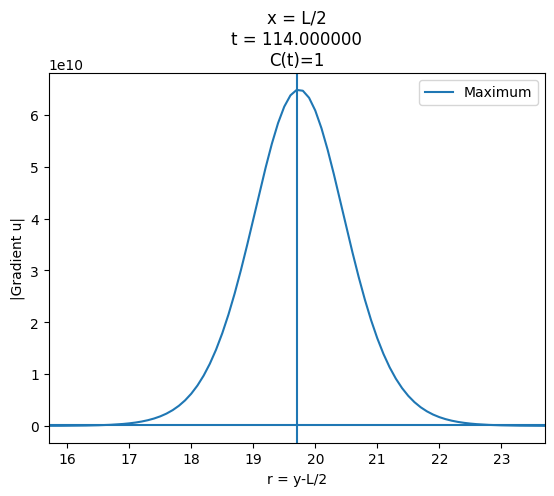

In [29]:
# Plot a slice
import scipy.stats


plt.plot(y-L/2, Z[int(len(y)/2)])
plt.title("x = L/2\nt = " + str(tmax) + "\nC(t)=1")
plt.xlabel("r = y-L/2")
plt.ylabel("|Gradient u|")


temp = Z[int(len(y)/2)][int(len(y)/2):len(y)]
index = np.argmax(temp) + int(len(y)/2)
Rlast = y[index]-L/2
eps = 4
plt.xlim(Rlast-eps,Rlast+eps)
plt.axvline(Rlast, label="Maximum")
plt.axhline(1e8)
plt.legend()

print(scipy.stats.skew(Z[int(len(y)/2)]))

### Plot R^2 extimate with integral of gradient method

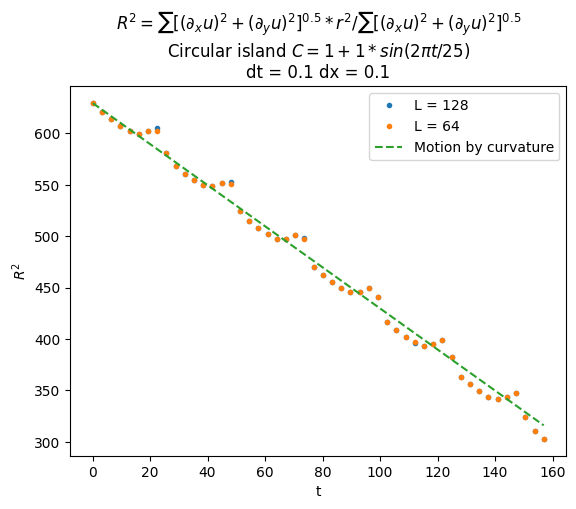

In [ ]:
fig, ax = plt.subplots()
experiments_list = ["C0=1 A=1 R0=25 T=25 grad L=128", "C0=1 A=1 R0=25 T=25 grad"]
for experiment_folder in experiments_list:
    for folder in sorted(os.listdir("../.saves/" + experiment_folder), reverse=True):
        f = open("../.saves/" + experiment_folder + "/" + folder + "/fileRadiout.dat", "r")
        N = 10000
        tt = np.zeros(N)
        R2 = np.zeros(N)

        i = 0
        for row in f:
            a, b = row.split(" ")
            tt[i] = float(a)
            R2[i] = float(b)
            i = i + 1
        f.close()
        tt = tt[0:i]
        R2 = R2[0:i]

        f = open("../.saves/" + experiment_folder + "/" + folder + "/label.dat", "r")
        labell = "Experiment " + experiment_folder
        for row in f:
            labell = row
        if row == "":
            labell = experiment_folder
        ax.plot(tt, R2,'.', label=labell)


R2_expected = R2[0]*np.ones(len(tt))-2*tt
ax.plot(tt, R2_expected,'--',label="Motion by curvature")
ax.set_xlabel("t")
ax.set_ylabel("$R^2$")    # Plot R^2-R0^2 in order to have a quantity independent on R0 (expected value = -2t)
ax.grid()
title = ""
title = title + "$R^2 = \sum[(\partial_x u)^2 + (\partial_y u)^2]*r^2 / \sum [(\partial_x u)^2 + (\partial_y u)^2]$"
title = title + "\nCircular island " 
#title = title + "R0 = "+str(R0)+"\n"
title = title + "$C = "+ str(C0) + " + "+str(A)+"*sin(2\pi t/"+str(T)+")$\n"
#title = title + "C=0.1\n"
title = title + "dt = " + str(dt)
title = title + " dx = " + str(dx)
#title = title + " L = " + str(L)

#ax.set_xlim(0,5)

ax.grid()
ax.set_title(title)
ax.legend()

In [ ]:
R2[1]-R2[0]

0.3566066683688405